In [1]:
#basic 
import pandas as pd
import numpy as np
import math as math
%precision %.4f
import warnings
warnings.filterwarnings('ignore')

#SQL server
import pyodbc

# visualisation
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [14,14]
%matplotlib inline
plt.style.use('seaborn')

# sklearn
from sklearn.cluster import KMeans,DBSCAN
import missingno as msno
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

#networkx
import networkx as nx
import time 


#output
from prettytable import PrettyTable


In [2]:
#creating a connection string
conn_str = (
    r'Driver={ODBC Driver 17 for SQL Server};'
    r'Server=RAMANATHAN\SQLEXPRESS;'
    r'Trusted_Connection=yes;'
    r'Database=PAI;'
)

conn = pyodbc.connect(conn_str)

In [3]:
#read_data
df_netflix = pd.read_sql('SELECT * FROM titles_netflix', conn)
df_amazon = pd.read_sql('SELECT * FROM titles_prime', conn)
df_disney = pd.read_sql('SELECT * FROM titles_disney', conn)

In [4]:
#adding addition column for concatination
df_netflix['dataset_name'] = 'Netflix'
df_amazon['dataset_name'] = 'AmazonPrime'
df_disney['dataset_name'] = 'DisneyPlus'

In [5]:
#concatination of three datasets
df = pd.concat([df_netflix, df_amazon, df_disney], axis=0)

In [6]:
df.shape

(18864, 19)

In [7]:
#droping Duplicates
df_movies = df.drop_duplicates(subset=[col for col in df.columns if col != 'dataset_name'],keep='first')
#df_movies = df.drop_duplicates()


In [8]:
#reseting index as we dropped some columns
df_movies = df_movies.reset_index(drop=True)

In [9]:
df_movies.shape

(18853, 19)

## Exploratory Data Analysis

In [10]:
df_movies.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,char_name,character,role,dataset_name
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1,None,None,None,0.601,None,None,None,None,Netflix
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119,"['drama', 'sport']",['US'],None,tt0075148,8.1,588100,106.361,7.782,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR,Netflix
2,tm17823,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110,"['romance', 'comedy']",['US'],None,tt0077631,7.2,283316,33.16,7.406,John Travolta,Danny Zuko,ACTOR,Netflix
3,tm191099,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129,"['crime', 'drama', 'comedy', 'music']",['US'],None,tt0070735,8.3,266738,24.616,8.02,Paul Newman,Henry Gondorff,ACTOR,Netflix
4,tm69975,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119,"['drama', 'sport']",['US'],None,tt0079817,7.3,216307,75.699,7.246,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR,Netflix


In [11]:
df_movies.describe()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,char_name,character,role,dataset_name
count,18853,18853,18853,18677,18853,8478,18853,18853,18853,4393,17278,16766,16727,18191,16330,17349,15791,17349,18853
unique,18704,18301,2,18514,112,12,212,3813,873,62,17133,96,8769,10365,2551,11733,11054,2,3
top,tm984484,Cinderella,MOVIE,Add a Plot »,2021,R,90,['comedy'],['US'],1,tt0075148,6.4,10.0,0.6,6.0,Roy Rogers,Self,ACTOR,AmazonPrime
freq,2,5,14460,4,2152,1848,664,1400,8891,1396,2,549,46,782,578,47,807,16832,10870


In [12]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18853 entries, 0 to 18852
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    18853 non-null  object
 1   title                 18853 non-null  object
 2   type                  18853 non-null  object
 3   description           18677 non-null  object
 4   release_year          18853 non-null  object
 5   age_certification     8478 non-null   object
 6   runtime               18853 non-null  object
 7   genres                18853 non-null  object
 8   production_countries  18853 non-null  object
 9   seasons               4393 non-null   object
 10  imdb_id               17278 non-null  object
 11  imdb_score            16766 non-null  object
 12  imdb_votes            16727 non-null  object
 13  tmdb_popularity       18191 non-null  object
 14  tmdb_score            16330 non-null  object
 15  char_name             17349 non-null

In [13]:
#all data from DB are object, converting the Numerical columns to Float
df_movies = df_movies.astype({'runtime': float, 'seasons': float, 'imdb_score': float, 'imdb_votes': float, 'tmdb_popularity': float,'tmdb_score': float})


In [14]:
df_movies.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,char_name,character,role,dataset_name
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51.0,['documentation'],['US'],1.0,None,NaN,NaN,0.601,NaN,None,None,None,Netflix
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119.0,"['drama', 'sport']",['US'],NaN,tt0075148,8.1,588100.0,106.361,7.782,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR,Netflix
2,tm17823,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110.0,"['romance', 'comedy']",['US'],NaN,tt0077631,7.2,283316.0,33.160,7.406,John Travolta,Danny Zuko,ACTOR,Netflix
3,tm191099,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129.0,"['crime', 'drama', 'comedy', 'music']",['US'],NaN,tt0070735,8.3,266738.0,24.616,8.020,Paul Newman,Henry Gondorff,ACTOR,Netflix
4,tm69975,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119.0,"['drama', 'sport']",['US'],NaN,tt0079817,7.3,216307.0,75.699,7.246,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR,Netflix


In [15]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18853 entries, 0 to 18852
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    18853 non-null  object 
 1   title                 18853 non-null  object 
 2   type                  18853 non-null  object 
 3   description           18677 non-null  object 
 4   release_year          18853 non-null  object 
 5   age_certification     8478 non-null   object 
 6   runtime               18853 non-null  float64
 7   genres                18853 non-null  object 
 8   production_countries  18853 non-null  object 
 9   seasons               4393 non-null   float64
 10  imdb_id               17278 non-null  object 
 11  imdb_score            16766 non-null  float64
 12  imdb_votes            16727 non-null  float64
 13  tmdb_popularity       18191 non-null  float64
 14  tmdb_score            16330 non-null  float64
 15  char_name          

In [16]:
df_movies.isna().sum()

id                          0
title                       0
type                        0
description               176
release_year                0
age_certification       10375
runtime                     0
genres                      0
production_countries        0
seasons                 14460
imdb_id                  1575
imdb_score               2087
imdb_votes               2126
tmdb_popularity           662
tmdb_score               2523
char_name                1504
character                3062
role                     1504
dataset_name                0
dtype: int64

<Axes: >

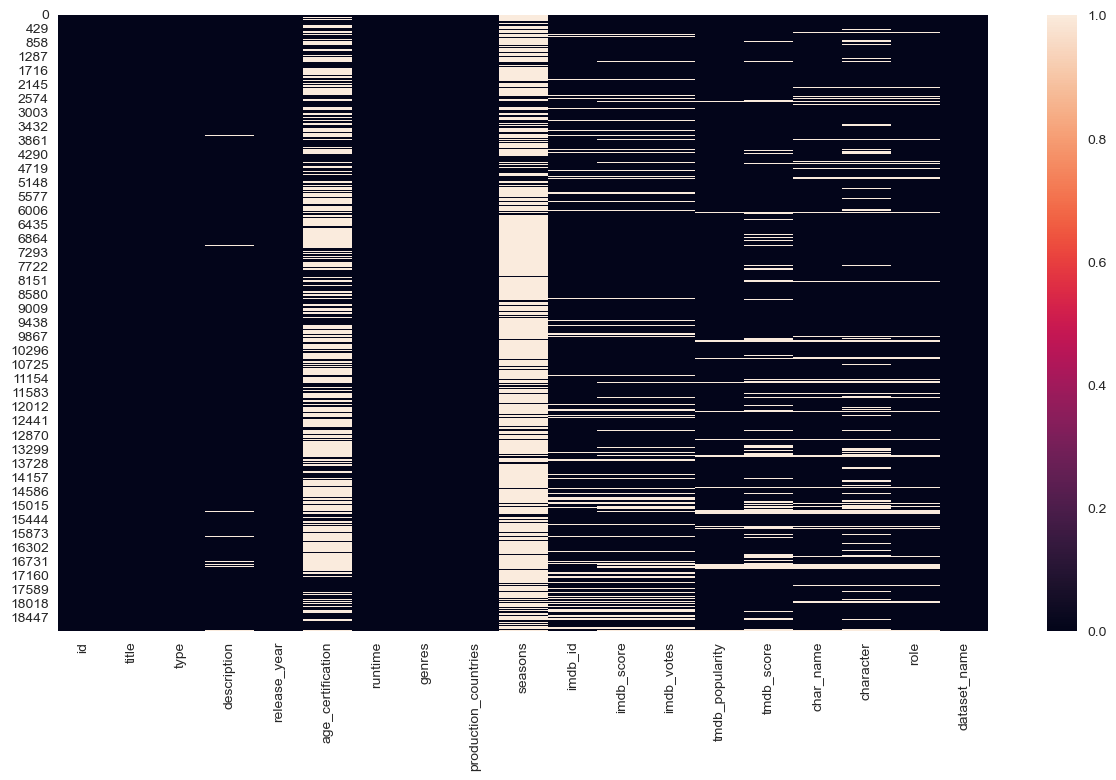

In [17]:
#Visualization of Null values
plt.figure(figsize=(15, 8))
sns.heatmap(df_movies.isnull())

In [18]:
# percentile of missing values
round(100*(df_movies.isnull().sum()/len(df_movies.index)),2).sort_values(ascending = False)

seasons                 76.70
age_certification       55.03
character               16.24
tmdb_score              13.38
imdb_votes              11.28
imdb_score              11.07
imdb_id                  8.35
role                     7.98
char_name                7.98
tmdb_popularity          3.51
description              0.93
id                       0.00
title                    0.00
production_countries     0.00
genres                   0.00
runtime                  0.00
release_year             0.00
type                     0.00
dataset_name             0.00
dtype: float64

### Handeling Missing Values

In [19]:
null_counts = df_movies.groupby('type')['seasons'].apply(lambda x: x.isnull().sum())
null_counts

type
MOVIE    14460
SHOW         0
Name: seasons, dtype: int64

In [20]:
#filling Season with 0
#This shows that all movies have seasons column as null, since its of type float64 adding 0 for all missing value
df_movies['seasons'] = df_movies['seasons'].fillna(0)

In [21]:
#age_certification   
df_movies['age_certification'].unique()  

array(['TV-MA', 'PG', 'R', 'TV-14', None, 'TV-PG', 'PG-13', 'TV-Y',
       'TV-Y7', 'TV-G', 'G', 'NC-17', 'TV-Y7-FV'], dtype=object)

In [22]:
df_movies['age_certification'] = df_movies['age_certification'].fillna('NA')

In [23]:
# Calculate the mean value of tmdb_score for movies and series
movie_mean_ts = df_movies.loc[df_movies['type'] == 'MOVIE', 'tmdb_score'].mean().round(2)
series_mean_ts = df_movies.loc[df_movies['type'] == 'SHOW', 'tmdb_score'].mean().round(2)

# Calculate the mean value of imdb_votes for movies and series
movie_mean_iv = df_movies.loc[df_movies['type'] == 'MOVIE', 'imdb_votes'].mean().round(2)
series_mean_iv = df_movies.loc[df_movies['type'] == 'SHOW', 'imdb_votes'].mean().round(2)

# Calculate the mean value of imdb_score for movies and series
movie_mean_is = df_movies.loc[df_movies['type'] == 'MOVIE', 'imdb_score'].mean().round(2)
series_mean_is = df_movies.loc[df_movies['type'] == 'SHOW', 'imdb_score'].mean().round(2)



In [24]:
#filling with Mean Values coresponding to movie or show
df_movies.loc[df_movies['type'] == 'MOVIE', 'tmdb_score'] = df_movies.loc[df_movies['type'] == 'MOVIE', 'tmdb_score'].fillna(movie_mean_ts)
df_movies.loc[df_movies['type'] == 'SHOW', 'tmdb_score'] = df_movies.loc[df_movies['type'] == 'SHOW', 'tmdb_score'].fillna(series_mean_ts)


df_movies.loc[df_movies['type'] == 'MOVIE', 'imdb_votes'] = df_movies.loc[df_movies['type'] == 'MOVIE', 'imdb_votes'].fillna(movie_mean_iv)
df_movies.loc[df_movies['type'] == 'SHOW', 'imdb_votes'] = df_movies.loc[df_movies['type'] == 'SHOW', 'imdb_votes'].fillna(series_mean_iv)


df_movies.loc[df_movies['type'] == 'MOVIE', 'imdb_score'] = df_movies.loc[df_movies['type'] == 'MOVIE', 'imdb_score'].fillna(movie_mean_is)
df_movies.loc[df_movies['type'] == 'SHOW', 'imdb_score'] = df_movies.loc[df_movies['type'] == 'SHOW', 'imdb_score'].fillna(series_mean_is)

In [25]:
#filling with NA values
#imdb_id 
df_movies['imdb_id'] = df_movies['imdb_id'].fillna('NA')

#description
df_movies['description'] = df_movies['description'].fillna('NA')

#role
df_movies['role'] = df_movies['role'].fillna('NA')

#char_name
df_movies['char_name'] = df_movies['char_name'].fillna('NA')

#character
df_movies['character'] = df_movies['character'].fillna('NA')

In [26]:
#using median value for tmdb_popularity
tmdb_subset = df_movies[df_movies['tmdb_popularity'].isnull()]
median_popularity = round(df_movies['tmdb_popularity'].median(), 2)

In [27]:
df_movies['tmdb_popularity'] = df_movies['tmdb_popularity'].fillna(median_popularity)

In [28]:
df_movies.type.value_counts()

MOVIE    14460
SHOW      4393
Name: type, dtype: int64

In [29]:
# percentile of missing values after data handling
round(100*(df_movies.isnull().sum()/len(df_movies.index)),2).sort_values(ascending = False)

id                      0.0
imdb_id                 0.0
role                    0.0
character               0.0
char_name               0.0
tmdb_score              0.0
tmdb_popularity         0.0
imdb_votes              0.0
imdb_score              0.0
seasons                 0.0
title                   0.0
production_countries    0.0
genres                  0.0
runtime                 0.0
age_certification       0.0
release_year            0.0
description             0.0
type                    0.0
dataset_name            0.0
dtype: float64

### EDA

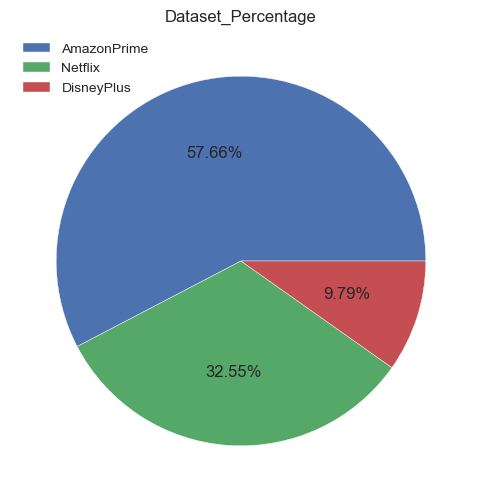

In [30]:
#pie chart to show data distribution
plt.figure(figsize=(10, 6))
plt.pie(list(df_movies['dataset_name'].value_counts()),autopct='%0.2f%%')
plt.title("Dataset_Percentage")
plt.legend(df_movies['dataset_name'].value_counts().index.tolist())
plt.show()

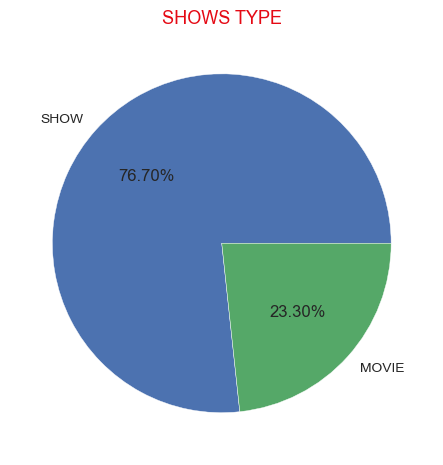

In [31]:
#Plot to show Which type is more movie or show
plt.pie(df_movies.groupby(['type'])['type'].count(), labels=df_movies['type'].unique(), autopct='%1.2f%%')
plt.title("SHOWS TYPE", color="#E50914",fontsize=13)
plt.show()

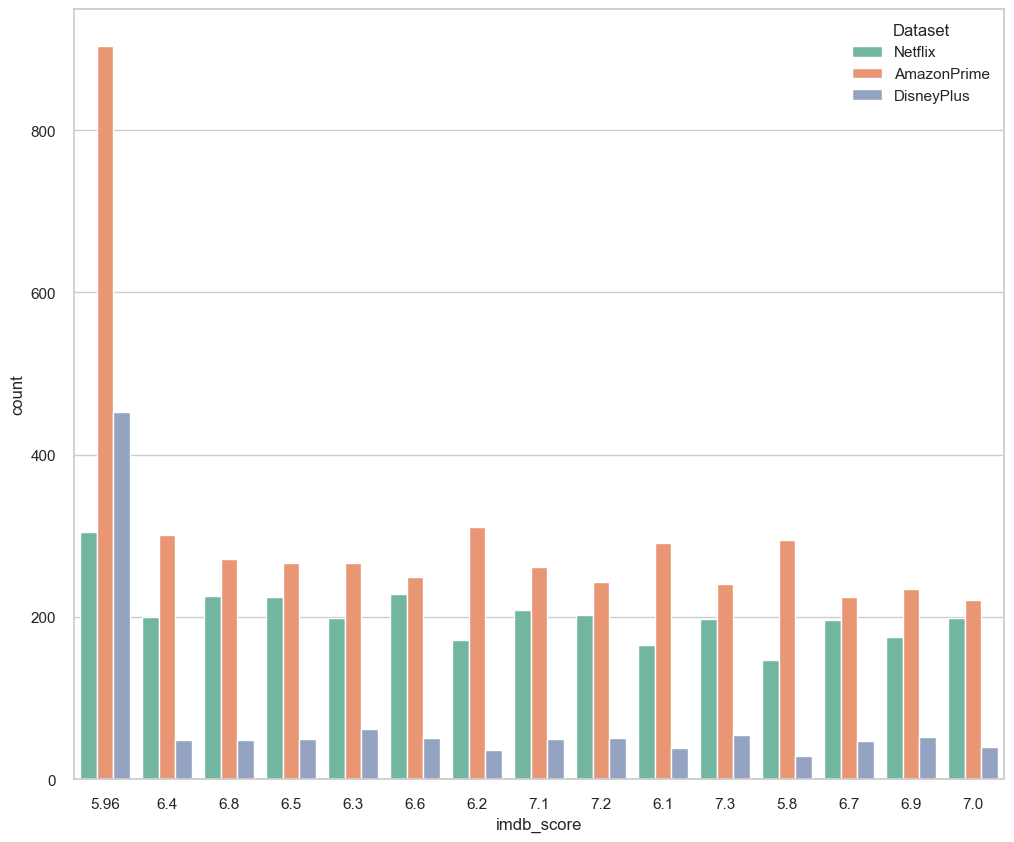

In [32]:
#bar graph to show count of imdb scores
plt.figure(figsize=(12,10))
sns.set(style="whitegrid")
ax = sns.countplot(x="imdb_score", data=df_movies,hue="dataset_name", palette="Set2", order=df_movies['imdb_score'].value_counts().index[0:15])
ax.legend(title="Dataset")
plt.show()

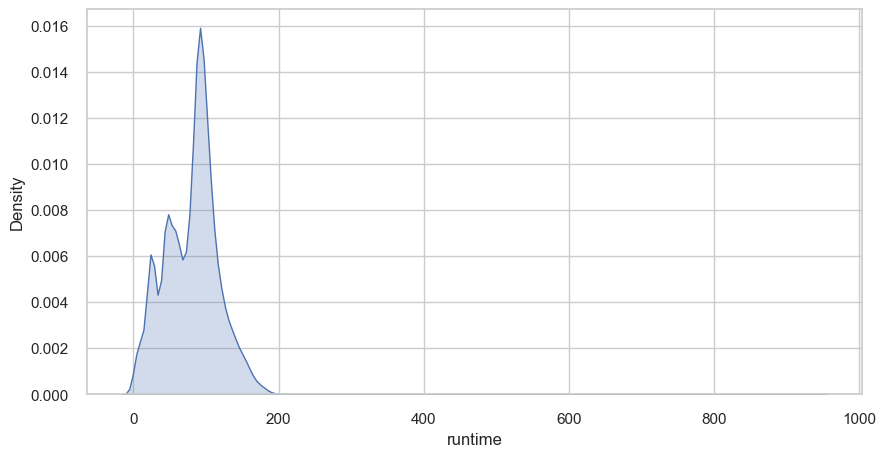

In [33]:
#histogram to show the runtime distribution
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_movies['runtime'], shade=True)
sns.set(style='darkgrid')

<Axes: xlabel='count', ylabel='release_year'>

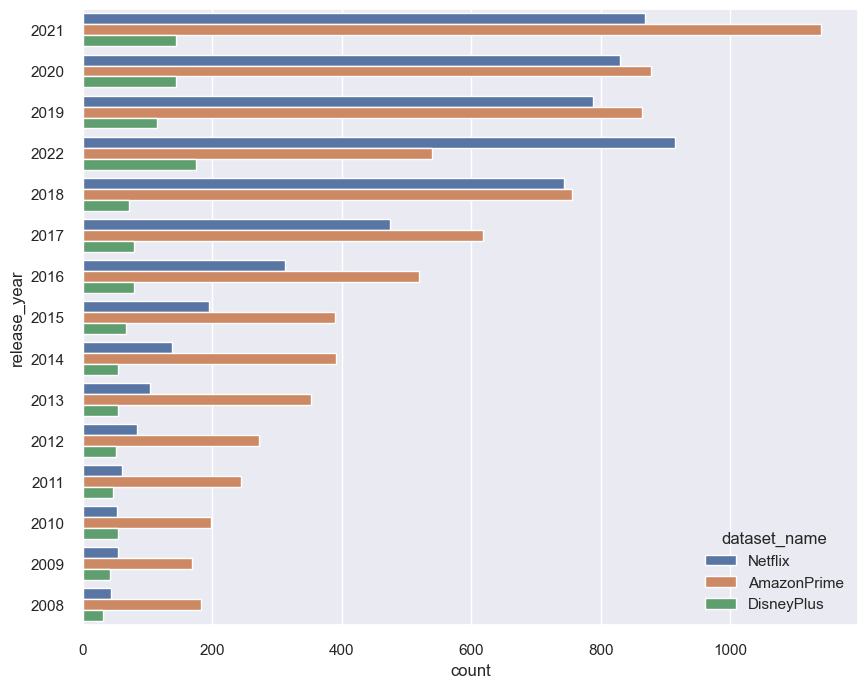

In [34]:
#bargraph to show count of movies released every year
plt.figure(figsize=(10, 8))
sns.countplot(data=df_movies, y="release_year",hue="dataset_name", order=df_movies['release_year'].value_counts().index[0:15])

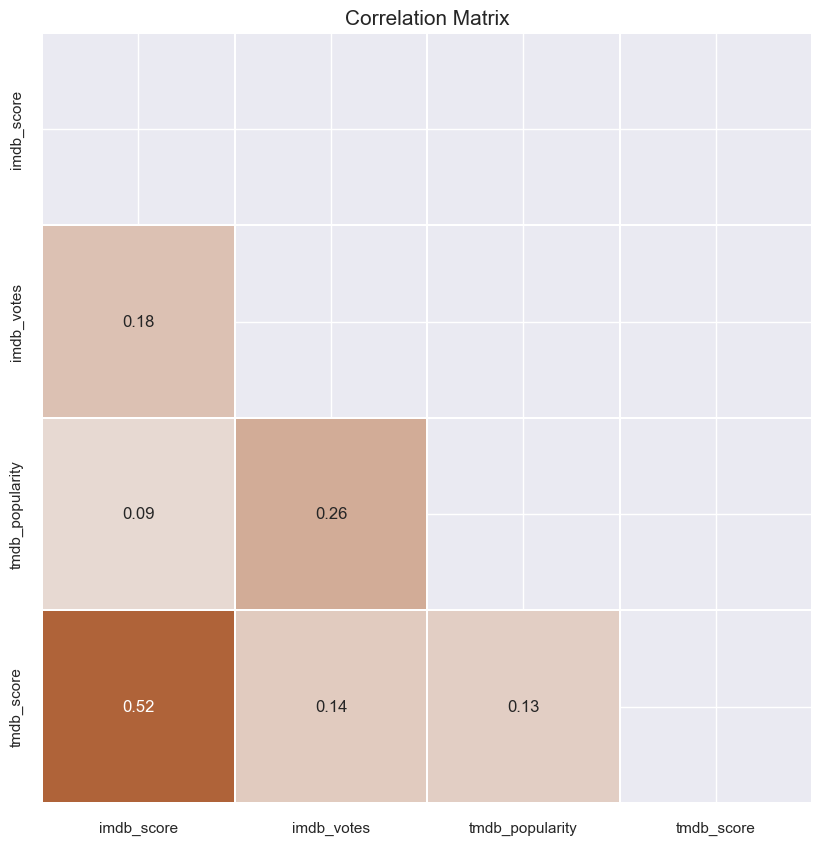

In [35]:
#coorelation matrix
features = ['imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'
]
correlation_matrix = df_movies[features].corr()

f, ax = plt.subplots(figsize=(12, 10))
show = sns.heatmap(correlation_matrix, mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), cmap=sns.diverging_palette(130, 30, as_cmap=True), 
    center=0, square=True, linewidths=.1, cbar=False, ax=ax, annot=True,
)
show = ax.set_title("Correlation Matrix", fontsize=15)

<Axes: title={'center': 'Top Production Countries'}, xlabel='production_countries', ylabel='count'>

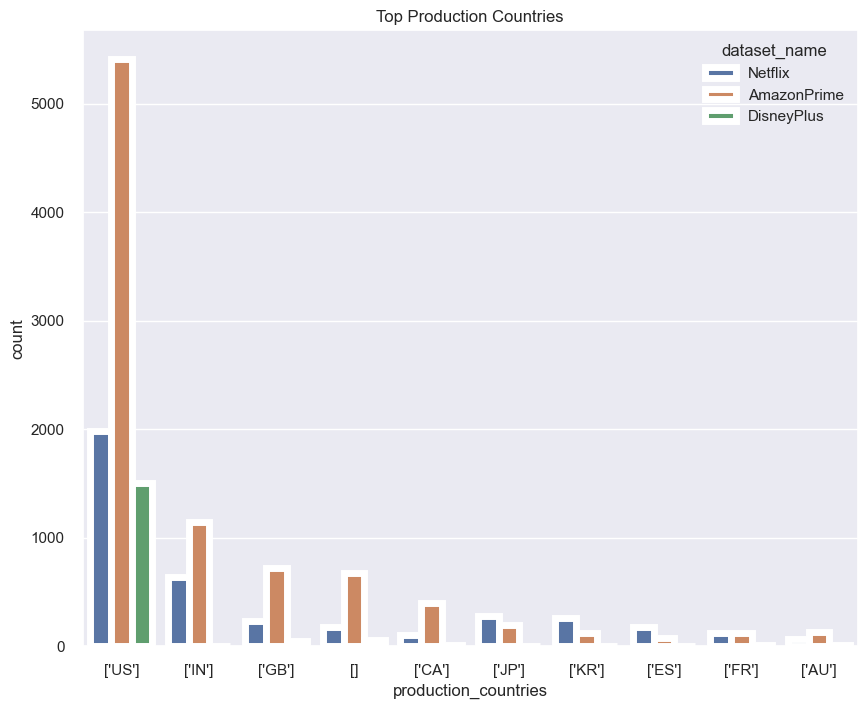

In [36]:
#bargraph to show count of production countried on each platform
plt.figure(figsize = (10,8))
plt.title('Top Production Countries')
sns.countplot(x='production_countries', data = df_movies,hue='dataset_name',order = df_movies['production_countries'].value_counts().index[:10] ,linewidth =5)

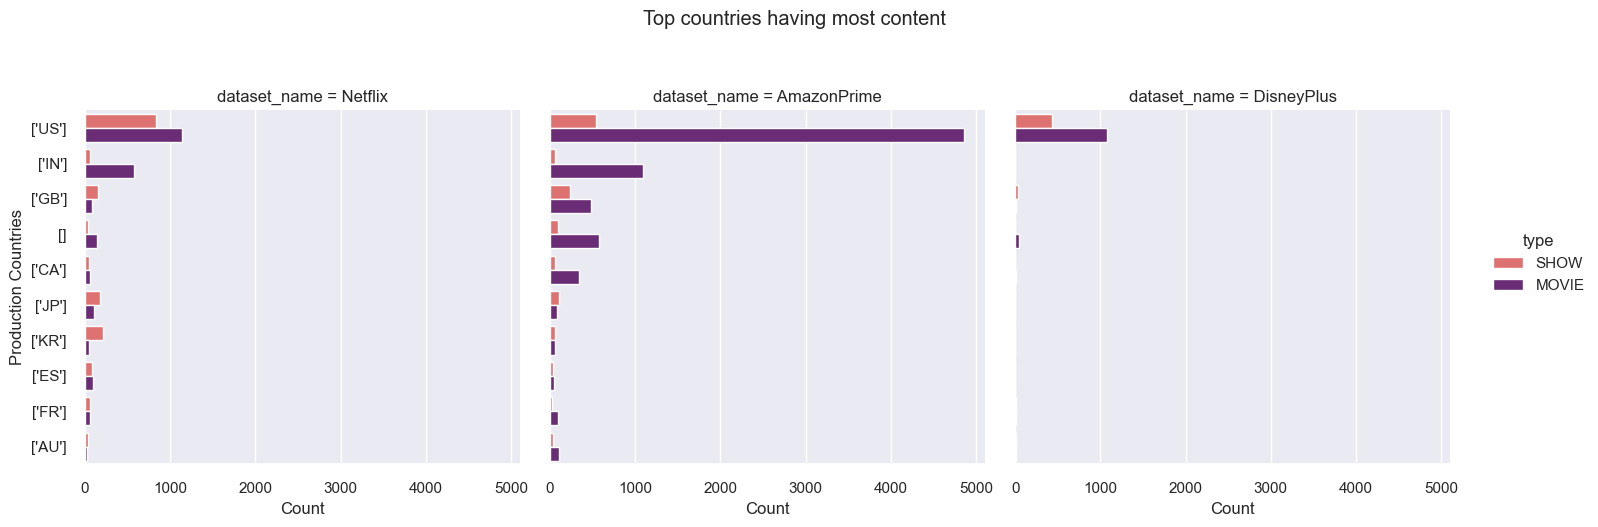

In [37]:
#plot to show count of movies per country in each dataset
fig = sns.catplot(kind='count', data=df_movies, y='production_countries', order=df_movies['production_countries'].value_counts().index[0:10], hue='type', col='dataset_name', palette='magma_r')
fig.fig.suptitle('Top countries having most content', y=1.05)
fig.set_axis_labels(y_var='Production Countries', x_var='Count')

fig.tight_layout()

plt.show()

In [38]:
df_movies['genres'] = df_movies['genres'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
df_movies['main_genre'] = df_movies['genres'].str.split(',').str[0]

In [39]:
df_movies['main_genre'].unique()

array(['documentation', 'drama', 'romance', 'crime', 'fantasy', 'comedy',
       'thriller', 'action', 'animation', 'family', 'reality', 'scifi',
       'western', 'horror', '', 'war', 'music', 'history', 'sport',
       'european'], dtype=object)

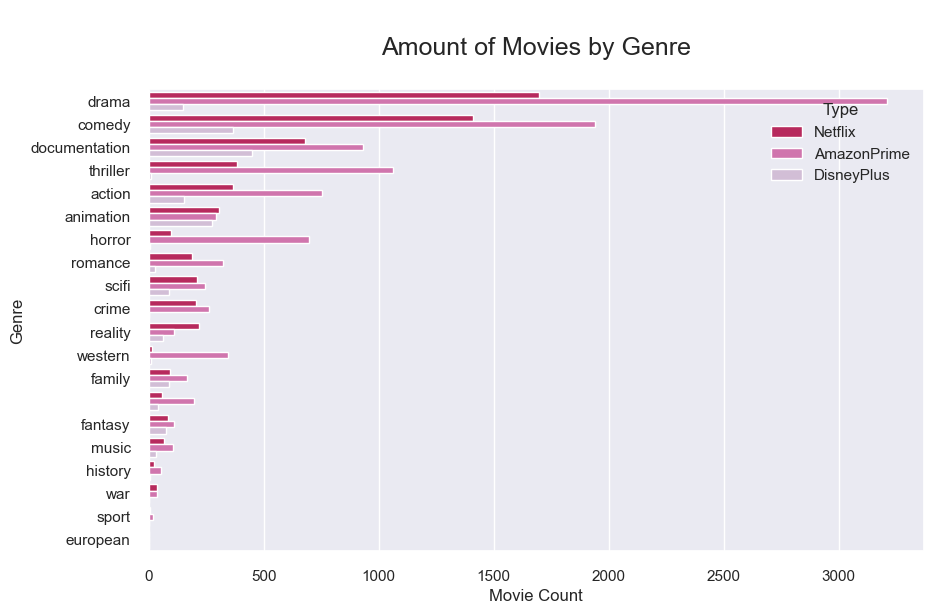

In [40]:
#count of movies per Genre
bp_df = pd.DataFrame(df_movies.main_genre.value_counts())
order = bp_df.index
plt.figure(figsize=(10,6))
plt.title('\nAmount of Movies by Genre\n', fontsize=18)
sns.countplot(y=df_movies.main_genre, palette='PuRd_r', order=order, hue=df_movies.dataset_name)
plt.xlabel('Movie Count')
plt.ylabel('Genre')
plt.legend(title='Type', loc='upper right')
plt.show()

In [41]:
df_movies.loc[df_movies['type'] == 'MOVIE', ['seasons']] = 0

In [42]:
df_movies.describe()

,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,18853.000000,18853.000000,18853.000000,1.885300e+04,18853.000000,18853.000000
mean,80.173288,0.550735,6.211235,1.791361e+04,13.002133,6.296795
std,37.173154,1.832943,1.235269,8.025163e+04,51.532705,1.344348
min,0.000000,0.000000,1.100000,5.000000e+00,0.000153,0.500000
25%,52.000000,0.000000,5.600000,2.270000e+02,1.891000,5.750000
50%,86.000000,0.000000,6.200000,1.366000e+03,4.110000,6.300000
75%,102.000000,0.000000,7.100000,1.254500e+04,10.253000,7.140000
max,940.000000,53.000000,9.900000,2.684317e+06,3187.531000,10.000000


# Models


## K-Means Clustering

In [43]:
#creating a df copy for working
var_df =  df_movies.copy()

In [44]:
var_df.set_index('title', inplace=True)

#### Expanding the componets by converting categorical variable to numerical variable

In [45]:
var_df.drop(['id', 'imdb_id'], axis=1, inplace=True)


In [46]:
var_df.drop(['description', 'age_certification', 'char_name',	'character',	'role',	'dataset_name'], axis=1, inplace=True)

In [47]:
var_df['production_countries'] = var_df['production_countries'].str.replace(r"[", '').str.replace(r"'", '').str.replace(r"]", '')
var_df['lead_prod_country'] = var_df['production_countries'].str.split(',').str[0]

# Let's also add a number of countries, envolved in movie making, so that we save a little more data
var_df['prod_countries_cnt'] = var_df['production_countries'].str.split(',').str.len()
var_df.lead_prod_country = var_df.lead_prod_country.replace('', np.nan)


In [48]:
dummies = pd.get_dummies(var_df[['type', 'lead_prod_country', 'main_genre']], drop_first=True)
var_df_dum = pd.concat([var_df, dummies], axis=1)
var_df_dum.drop(['type', 'lead_prod_country', 'main_genre'], axis=1, inplace=True)

In [49]:
var_df_dum.drop(['genres', 'production_countries'], axis=1, inplace=True)

In [50]:
#minmax scaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(var_df_dum)
df_scaled = pd.DataFrame(df_scaled, columns=[var_df_dum.columns])
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,18853.0,0.870348,0.191215,0.0,0.873874,0.945946,0.972973,1.0
runtime,18853.0,0.085291,0.039546,0.0,0.055319,0.091489,0.108511,1.0
seasons,18853.0,0.010391,0.034584,0.0,0.000000,0.000000,0.000000,1.0
imdb_score,18853.0,0.580822,0.140371,0.0,0.511364,0.579545,0.681818,1.0
imdb_votes,18853.0,0.006672,0.029897,0.0,0.000083,0.000507,0.004672,1.0
...,...,...,...,...,...,...,...,...
main_genre_scifi,18853.0,0.028643,0.166804,0.0,0.000000,0.000000,0.000000,1.0
main_genre_sport,18853.0,0.001432,0.037817,0.0,0.000000,0.000000,0.000000,1.0
main_genre_thriller,18853.0,0.077229,0.266962,0.0,0.000000,0.000000,0.000000,1.0
main_genre_war,18853.0,0.003872,0.062107,0.0,0.000000,0.000000,0.000000,1.0


In [51]:
df_scaled.shape

(18853, 152)

#### Model

In [52]:
#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=143, svd_solver='full')
df_scaled_full = pca.fit(df_scaled).transform(df_scaled)

explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_),3)

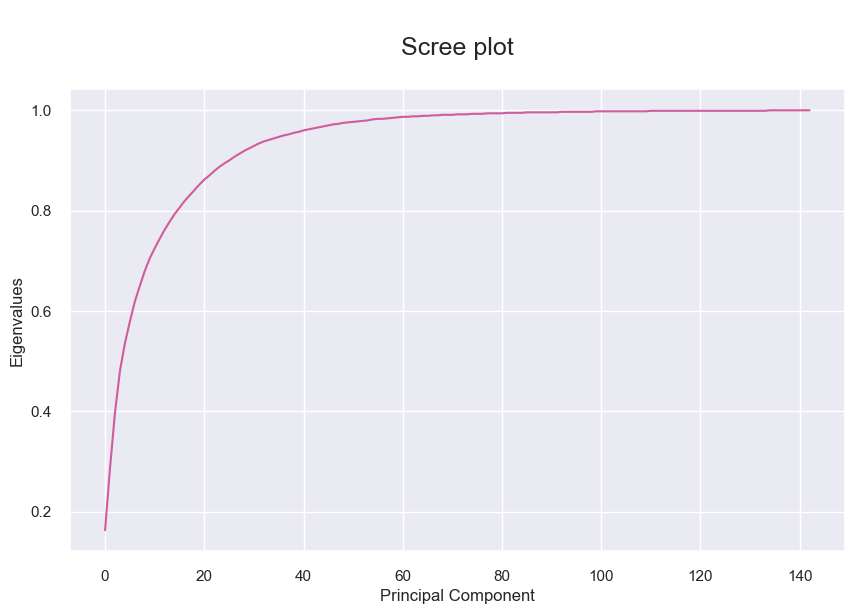

In [53]:
#elbow curve
plt.figure(figsize=(10,6))
plt.title('\nScree plot\n', fontsize=18)
plt.plot(np.arange(143), explained_variance, color='#D05C9C')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')
plt.show()

##### PCA

In [54]:
pca_60 = PCA(n_components=60, svd_solver='full')
df_scaled_60 = pca.fit(df_scaled).transform(df_scaled)

In [55]:
K = range(10, 80)
models = [KMeans(n_clusters = k, random_state=8, max_iter = 10000).fit(df_scaled_60) for k in K]
dist = [model.inertia_ for model in models]

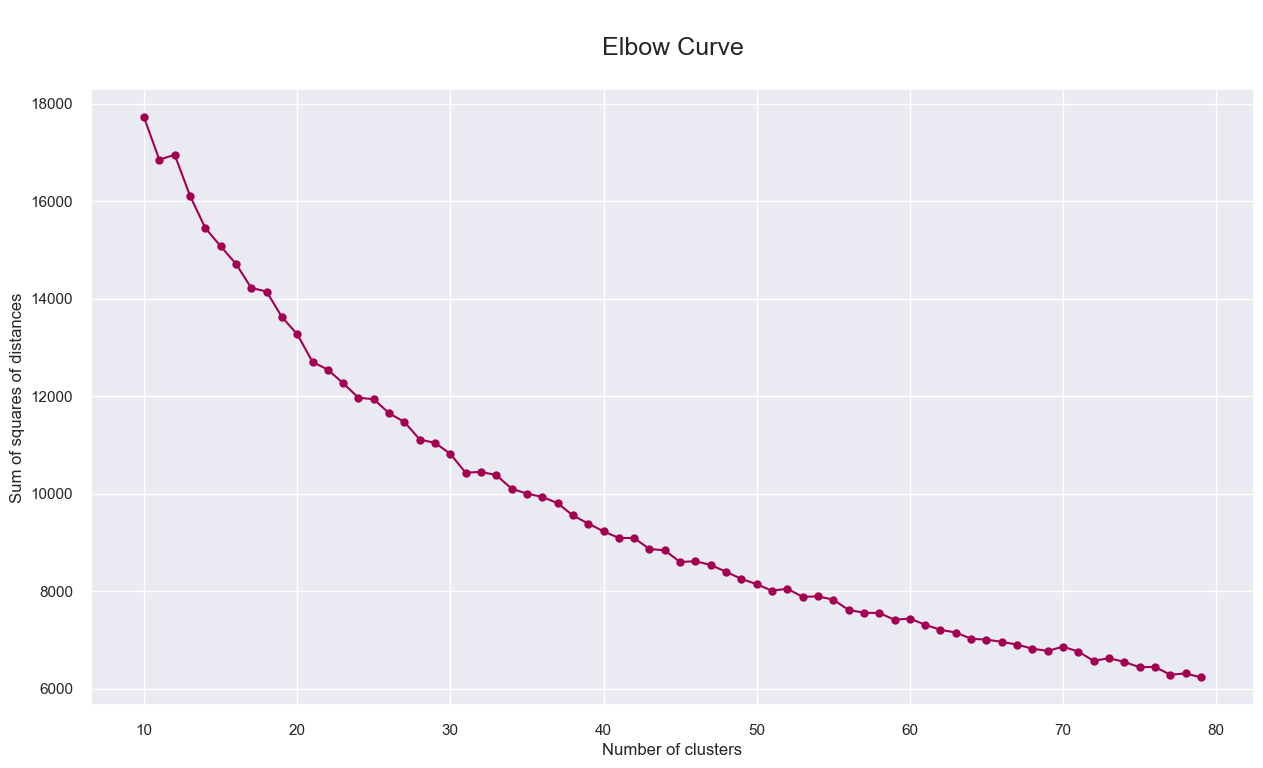

In [56]:
plt.figure(figsize=(15,8))
plt.plot(K, dist, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares of distances')
plt.title('\nElbow Curve\n', fontsize=18)
plt.show()

In [57]:
#clustering 
range_n_clusters = range(20, 41, 5)
for n_clusters in range_n_clusters:
    
    models1 = KMeans(n_clusters=n_clusters, random_state=8, max_iter=10000)
    model_labels = models1.fit_predict(df_scaled_60)
    
    silhouette_avg = silhouette_score(df_scaled_60, model_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

For n_clusters = 20 The average silhouette_score is : 0.33346818394358735
For n_clusters = 25 The average silhouette_score is : 0.355691224287475
For n_clusters = 30 The average silhouette_score is : 0.36479418676234543
For n_clusters = 35 The average silhouette_score is : 0.3973151087940325
For n_clusters = 40 The average silhouette_score is : 0.422253070661351


In [58]:
#final cluster-300
models_300 = KMeans(n_clusters=300, random_state=8, max_iter = 10000)
model_labels_300 = models_300.fit_predict(df_scaled_60)
silhouette_avg_300 = silhouette_score(df_scaled_60, model_labels_300)
print("For n_clusters =", 300, "The average silhouette_score is :", silhouette_avg_300)

For n_clusters = 300 The average silhouette_score is : 0.49879476255789884


## DBSCAN Model

In [59]:
from sklearn.decomposition import PCA
pca_10d = PCA(n_components=10)
PCs_10d = pd.DataFrame(pca_10d.fit_transform(df_scaled_60))

eps_array = [0.2, 0.5, 1]
min_samples_array = [5, 10, 30]

In [60]:
#DBSCAN model
for eps in eps_array:
  for min_samples in min_samples_array:
    clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(PCs_10d)
    cluster_labels = clusterer.labels_
    if len(set(cluster_labels)) == 1:
        continue
    silhouette_avg = silhouette_score(PCs_10d, cluster_labels)
    print("For eps =", eps,
          "For min_samples =", min_samples,
          "Count clusters =", len(set(cluster_labels)),
          "The average silhouette_score is :", silhouette_avg)

For eps = 0.2 For min_samples = 5 Count clusters = 69 The average silhouette_score is : 0.84706735160211
For eps = 0.2 For min_samples = 10 Count clusters = 64 The average silhouette_score is : 0.8472162146997322
For eps = 0.2 For min_samples = 30 Count clusters = 49 The average silhouette_score is : 0.839754458036185
For eps = 0.5 For min_samples = 5 Count clusters = 58 The average silhouette_score is : 0.8401793837693534
For eps = 0.5 For min_samples = 10 Count clusters = 55 The average silhouette_score is : 0.8395023668304733
For eps = 0.5 For min_samples = 30 Count clusters = 45 The average silhouette_score is : 0.8274047163161637


In [61]:
#DBSCAN after fixing hyperparameters
dbscan10d_model = DBSCAN(eps=0.2, min_samples=10).fit(PCs_10d)
print("For eps =", 0.2,
      "For min_samples =", 10,
      "Count clusters =", len(set(dbscan10d_model.labels_)),
      "The average silhouette_score is :", silhouette_score(PCs_10d, dbscan10d_model.labels_))

For eps = 0.2 For min_samples = 10 Count clusters = 64 The average silhouette_score is : 0.8472162146997322


## Using Networkx

In [62]:
df_movies.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,char_name,character,role,dataset_name,main_genre
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51.0,documentation,['US'],1.0,NA,7.04,14261.35,0.601,7.140,NA,NA,NA,Netflix,documentation
1,tm82169,Rocky,MOVIE,"When world heavyweight boxing champion, Apollo...",1976,PG,119.0,"drama, sport",['US'],0.0,tt0075148,8.10,588100.00,106.361,7.782,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR,Netflix,drama
2,tm17823,Grease,MOVIE,Australian good girl Sandy and greaser Danny f...,1978,PG,110.0,"romance, comedy",['US'],0.0,tt0077631,7.20,283316.00,33.160,7.406,John Travolta,Danny Zuko,ACTOR,Netflix,romance
3,tm191099,The Sting,MOVIE,A novice con man teams up with an acknowledged...,1973,PG,129.0,"crime, drama, comedy, music",['US'],0.0,tt0070735,8.30,266738.00,24.616,8.020,Paul Newman,Henry Gondorff,ACTOR,Netflix,crime
4,tm69975,Rocky II,MOVIE,After Rocky goes the distance with champ Apoll...,1979,PG,119.0,"drama, sport",['US'],0.0,tt0079817,7.30,216307.00,75.699,7.246,Sylvester Stallone,"Robert ""Rocky"" Balboa",ACTOR,Netflix,drama


In [63]:
# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df_movies['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                            min_df=1,       # only use words that appear at least X times
                            stop_words='english', # remove stop words
                            lowercase=True, # Convert everything to lower case 
                            use_idf=True,   # Use idf
                            norm=u'l2',     # Normalization
                            smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)


In [64]:

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names_out()

# print the centers of the clusters
#for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df_movies['description'])
# new column cluster based on the description
df_movies['cluster'] = kmeans.predict(request_transform) 

df_movies['cluster'].value_counts().head()

28     14099
135      734
145      694
30       617
65       531
Name: cluster, dtype: int64

In [65]:
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]

In [66]:
#defining nodes and edges
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df_movies.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['id'],label="MOVIE",mtype=rowi['type'],rating=rowi['age_certification'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")

    for element in rowi['genres']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['production_countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    for element in rowi['char_name']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['role']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['character']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="CHA_IN")
    for element in rowi['dataset_name']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="PLA_IN")
    #for element in rowi['tmdb_score']:
    #    G.add_node(element,label="RAT")
    #    G.add_edge(rowi['title'], element, label="RAT_IN")

    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df_movies['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time)) 

 iter 0 -- 0.0508115291595459 seconds --
 iter 1000 -- 16.237115383148193 seconds --
 iter 2000 -- 28.273186683654785 seconds --
 iter 3000 -- 42.789034843444824 seconds --
 iter 4000 -- 54.41839385032654 seconds --
 iter 5000 -- 66.19203615188599 seconds --
 iter 6000 -- 78.40975999832153 seconds --
 iter 7000 -- 90.51811003684998 seconds --
 iter 8000 -- 102.42534494400024 seconds --
 iter 9000 -- 114.60622215270996 seconds --
 iter 10000 -- 129.1647276878357 seconds --
 iter 11000 -- 141.2614462375641 seconds --
 iter 12000 -- 153.11524558067322 seconds --
 iter 13000 -- 164.8851819038391 seconds --
 iter 14000 -- 178.70456314086914 seconds --
 iter 15000 -- 190.63016390800476 seconds --
 iter 16000 -- 203.49746775627136 seconds --
 iter 17000 -- 216.09006094932556 seconds --
 iter 18000 -- 228.54139828681946 seconds --
 finish -- 242.97645831108093 seconds --


In [67]:
#definig graphs
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')


    nx.draw_networkx(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

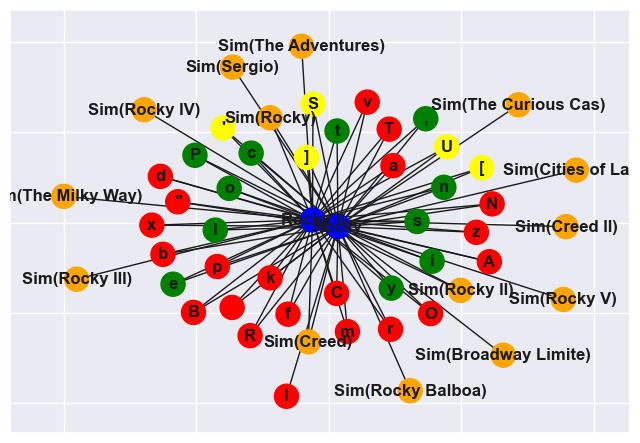

In [68]:
#subnode
list_in=["Rocky","Rocky II"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

## Recomendation Engine

In [69]:
#recommendation enging based on TF-IDF weights
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

In [70]:
#function to display output in better format
def output(result):
    table = PrettyTable()
    table.field_names = ["Movie Name", "Platform", "Score"]
    for i in range(5):
        dataset_name = df_movies.loc[df_movies['title'] == result.index[i], 'dataset_name'].values[0]
        table.add_row([result.index[i], dataset_name, round(result[i],2)])

    print(table)



In [71]:
#output
result = get_recommendation("The Dark Knight")

    

In [72]:
Cluster for output
reco=list(result.index[:4].values)
reco.extend(["The Dark Knight"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

SyntaxError: invalid syntax (3083512329.py, line 1)

In [ ]:
#display output
output(result)

+----------------------------------------------------+-------------+-------+
|                     Movie Name                     |   Platform  | Score |
+----------------------------------------------------+-------------+-------+
| Lego DC Comics - Super Heroes: Batman Be-Leaguered |   Netflix   |  4.54 |
|                 Starring Adam West                 | AmazonPrime |  4.16 |
|               The Great Muppet Caper               |  DisneyPlus |  3.54 |
|                 Monsters vs Aliens                 |   Netflix   |  3.54 |
|    Jeff Dunham's Very Special Christmas Special    |   Netflix   |  3.53 |
+----------------------------------------------------+-------------+-------+
